In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import SphericalVoronoi, cKDTree
from scipy.stats import pearsonr
from scipy import sparse
import xarray as xr
import pandas as pd

from itertools import combinations

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
import colorcet as cc

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx

import sys
import pickle
import copy
from glob import glob
from importlib import reload

sys.path.append('/scratch/daanr/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import community
import fieldsetter_cmems
import advectParticles

Stripy is not available on this machine.


In [2]:
reload(plot)
reload(community)
reload(fieldsetter_cmems)
reload(advectParticles)

Stripy is not available on this machine.


<module 'advectParticles' from '/scratch/daanr/arctic-connectivity/tools/advectParticles.py'>

In [9]:
readDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030/"
meanDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/"
fieldFiles = sorted(glob(readDir + "mercatorglorys12v1_gl12_mean_*.nc"))

psetdir = "/data/oceanparcels/output_data/data_Daan/community/psets/"
matdir = "/data/oceanparcels/output_data/data_Daan/community/matrices/"
netdir = "/data/oceanparcels/output_data/data_Daan/community/networks/"
comdir = "/data/oceanparcels/output_data/data_Daan/community/communities/"

In [75]:
with open('/scratch/daanr/meshes/ico_mesh_hex_r6.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBins = community.hexCountBins(meshDict['points'], 
                                np.degrees(meshDict['lons']), 
                                np.degrees(meshDict['lats']), 
                                meshDict['permutation'], 
                                meshDict['simplices'])
myMask = community.hexMask(myBins, -180, 180, 60, 90)
myMask.growToLevel(4)
myBins.calculate_voronoi(myMask, innerMaskLevel=2, outerMaskLevel=3)
#myBins.add_regular_rim()
myBins.calculate_neighbors()
del meshDict
with open("oceanMask_no_rim_Cico6.pickle", 'rb') as pickFile:
    myBins.oceanMask = pickle.load(pickFile)

In [84]:
myParts = community.particles.from_pickle('/scratch/daanr/meshes/ico_mesh_parts_deg_arctic_r11_delland.pickle')    

In [86]:
myParts.n

1450665

# March 2018

In [21]:
ice_ds_201803 = xr.open_dataset(meanDir + "mercatorglorys12v1_gl12_mean_201803.nc")

In [12]:
with open(comdir + f"ensemble_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico6_mt2/ensembleResults_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico6_mt2.pickle", 'rb') as pickFile:
        results = pickle.load(pickFile) 
        
codelengths_201803 = results['codelengths']
globalMixing_201803 = results['globalMixing']
globalCoherence_201803 = results['globalCoherence']
avg_mixing_201803 = results['avg_mixing']
avg_coherence_201803 = results['avg_coherence']
avg_boundary_201803 = results['avg_boundary']

In [13]:
qualityparametersDF_201803 = pd.DataFrame({"Codelength" : codelengths_201803,
                                           "Global Mixing" : globalMixing_201803,
                                           "Global Coherence" : globalCoherence_201803}, 
                                          )

In [14]:
qualityparametersDF_201803.corr()

,Codelength,Global Mixing,Global Coherence
Codelength,1.000000,-0.363149,0.284295
Global Mixing,-0.363149,1.000000,-0.515197
Global Coherence,0.284295,-0.515197,1.000000


In [15]:
qualityparametersDF_201803.corr(method=lambda x, y: pearsonr(x, y)[1])

,Codelength,Global Mixing,Global Coherence
Codelength,1.000000,2.044598e-04,4.149035e-03
Global Mixing,0.000204,1.000000e+00,4.146041e-08
Global Coherence,0.004149,4.146041e-08,1.000000e+00


In [16]:
qualityparametersDF_201803.mean()

Codelength          5.854816
Global Mixing       0.377408
Global Coherence    0.801119
dtype: float64

In [17]:
qualityparametersDF_201803.var()

Codelength          0.000030
Global Mixing       0.000006
Global Coherence    0.000040
dtype: float64

In [18]:
qualityparametersDF_201803.std()

Codelength          0.005488
Global Mixing       0.002479
Global Coherence    0.006298
dtype: float64

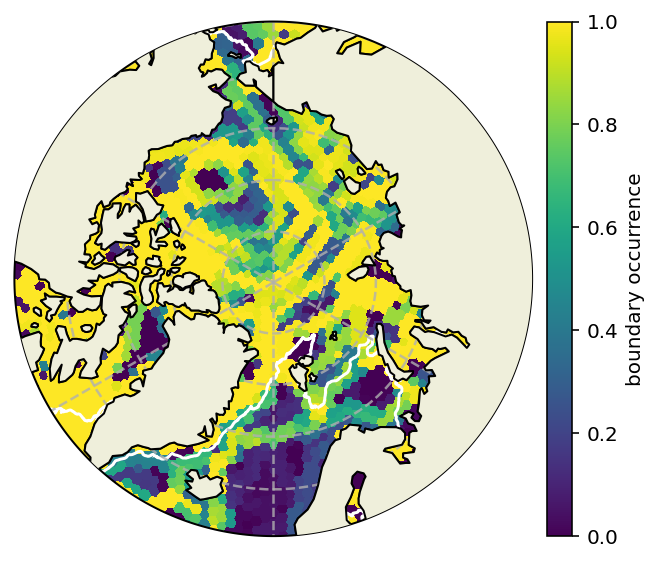

In [24]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_boundary_201803[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = 'viridis', vmin=0, vmax=1,
                                            size = (5,5),
#                                             export = f"{comName}.png",
                                            cbar=True,
                                            polar = True,
                                            units = "boundary occurrence"
                                            )
ax.contour(ice_ds_201803.longitude, ice_ds_201803.latitude[1680:], ice_ds_201803.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/average_boundary_ensemble_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico6_mt2.png", dpi=300, bbox_inches='tight')

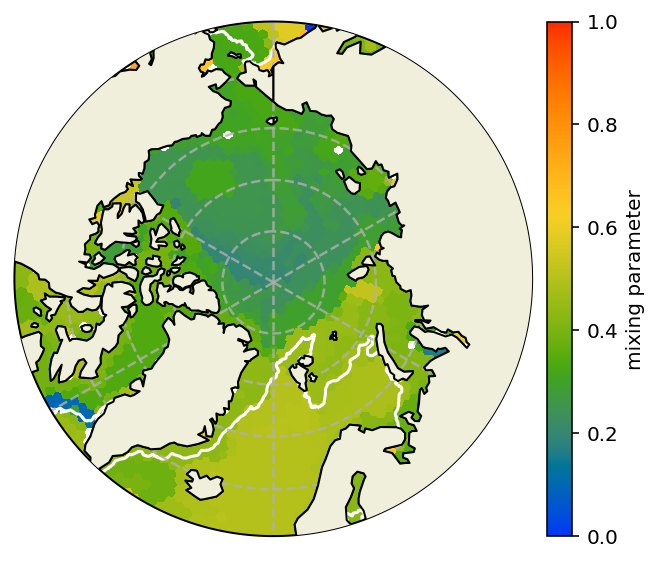

In [26]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_mixing_201803[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
#                                             export = f"{comName}.png",
                                             cbar=True,
                                             polar = True,
                                             units = "mixing parameter"
                                            )
ax.contour(ice_ds_201803.longitude, ice_ds_201803.latitude[1680:], ice_ds_201803.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/average_mixing_ensemble_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico6_mt2.png", dpi=300, bbox_inches='tight')

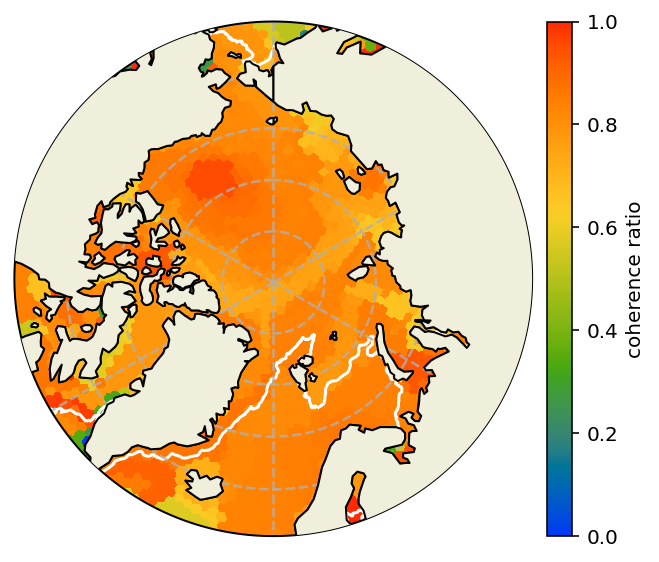

In [27]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_coherence_201803[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
#                                             export = f"{comName}.png",
                                             cbar=True,
                                             polar = True,
                                             units = "coherence ratio"
                                            )
ax.contour(ice_ds_201803.longitude, ice_ds_201803.latitude[1680:], ice_ds_201803.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/average_coherence_ensemble_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico6_mt2.png", dpi=300, bbox_inches='tight')

In [58]:
print("Indices of median codelength solutions:", np.argsort(qualityparametersDF_201803['Codelength'])[49],"and",np.argsort(qualityparametersDF_201803['Codelength'])[50])

Indices of median codelength solutions: 61 and 32


In [59]:
print("Solution 62")
print("Codelength: ", qualityparametersDF_201803['Codelength'][61])
print("Global Mixing: ", qualityparametersDF_201803['Global Mixing'][61])
print("Global Coherence: ", qualityparametersDF_201803['Global Coherence'][61])

Solution 62
Codelength:  5.85476
Global Mixing:  0.38032597324935474
Global Coherence:  0.8016723027032291


In [61]:
print("Solution 33")
print("Codelength: ", qualityparametersDF_201803['Codelength'][32])
print("Global Mixing: ", qualityparametersDF_201803['Global Mixing'][32])
print("Global Coherence: ", qualityparametersDF_201803['Global Coherence'][32])

Solution 33
Codelength:  5.85511
Global Mixing:  0.3767176822006386
Global Coherence:  0.8059285001801715


Text(0.5, 0, 'Codelength')

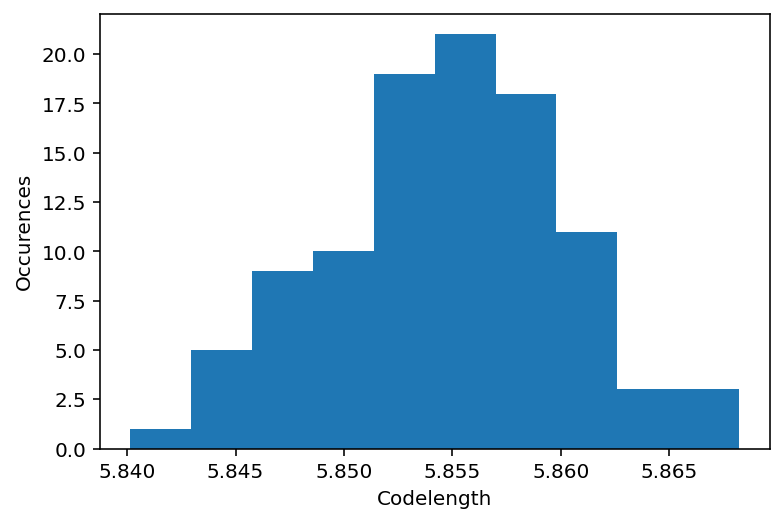

In [60]:
plt.hist(qualityparametersDF_201803['Codelength'], bins=10)
plt.ylabel("Occurences")
plt.xlabel("Codelength")

Text(0.5, 0, 'Global Mixing')

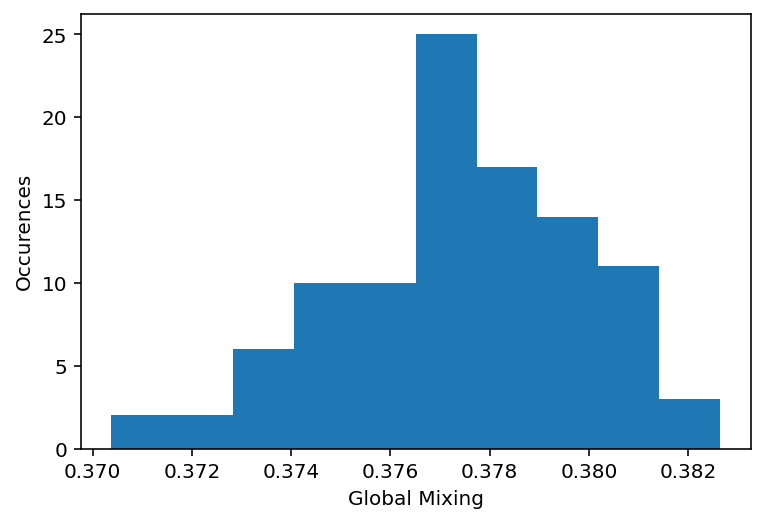

In [62]:
plt.hist(qualityparametersDF_201803['Global Mixing'], bins=10)
plt.ylabel("Occurences")
plt.xlabel("Global Mixing")

Text(0.5, 0, 'Global Coherence')

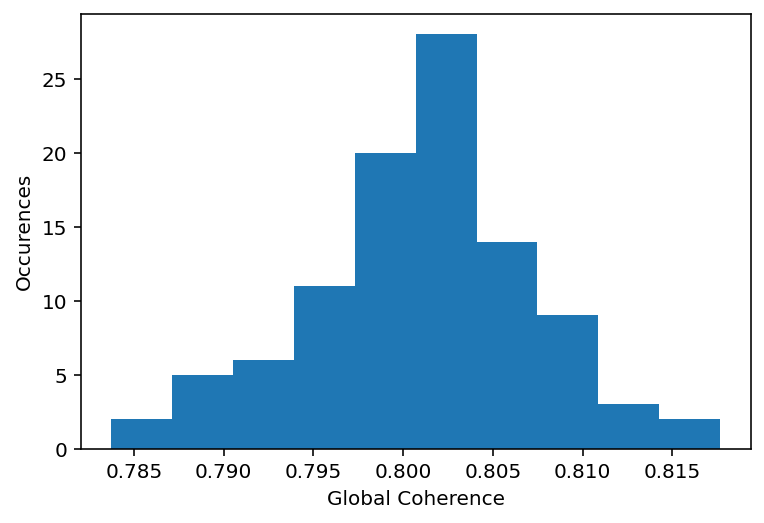

In [63]:
plt.hist(qualityparametersDF_201803['Global Coherence'], bins=10)
plt.ylabel("Occurences")
plt.xlabel("Global Coherence")

In [67]:
comName = f'masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico6_mt2_multirunN62'

In [79]:
transMat_201803 = community.transMat.from_counter_npz(matdir + f"masked_counter_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico6.npz")

In [81]:
myBins.load_communities(comdir + f"ensemble_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico6_mt2/{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_201803);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_201803);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.8016723027032291
Global Mixing Parameter 0.38032597324935474


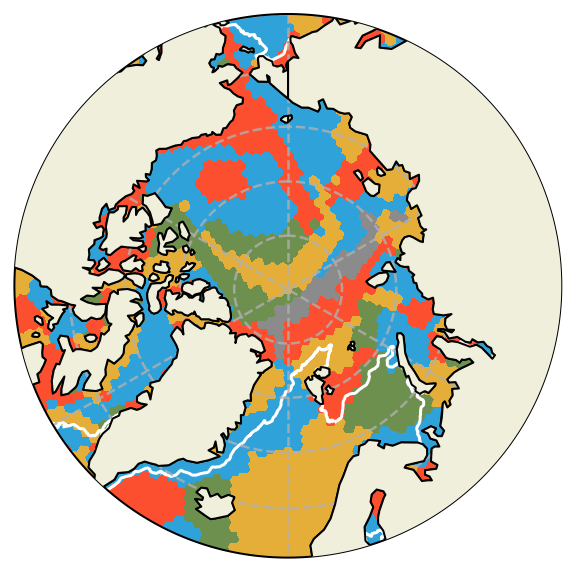

In [83]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = cc.cm.glasbey_hv,vmin=0, vmax=255,
                                            size = (5,5),
#                                             export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            )
ax.contour(ice_ds_201803.longitude, ice_ds_201803.latitude[1680:], ice_ds_201803.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/{comName}.png", dpi=300, bbox_inches='tight')

# 30 days

In [28]:
transMat_201803_subD30 = community.transMat.from_counter_npz(matdir + f"masked_counter_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico6_subD30.npz")

In [29]:
with open(comdir + f"ensemble_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico6_subD30_mt2/ensembleResults_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico6_subD30_mt2.pickle", 'rb') as pickFile:
        results = pickle.load(pickFile) 
        
codelengths_201803_subD30 = results['codelengths']
globalMixing_201803_subD30 = results['globalMixing']
globalCoherence_201803_subD30 = results['globalCoherence']
avg_mixing_201803_subD30 = results['avg_mixing']
avg_coherence_201803_subD30 = results['avg_coherence']
avg_boundary_201803_subD30 = results['avg_boundary']

In [30]:
qualityparametersDF_201803_subD30 = pd.DataFrame({"Codelength" : codelengths_201803_subD30,
                                    "Global Mixing" : globalMixing_201803_subD30,
                                    "Global Coherence" : globalCoherence_201803_subD30}, 
                                )

In [31]:
qualityparametersDF_201803_subD30.corr()

,Codelength,Global Mixing,Global Coherence
Codelength,1.000000,-0.160276,0.143215
Global Mixing,-0.160276,1.000000,-0.685459
Global Coherence,0.143215,-0.685459,1.000000


In [40]:
qualityparametersDF_201803_subD30.corr(method=lambda x, y: pearsonr(x, y)[1])

,Codelength,Global Mixing,Global Coherence
Codelength,1.000000,1.111768e-01,1.551751e-01
Global Mixing,0.111177,1.000000e+00,3.629694e-15
Global Coherence,0.155175,3.629694e-15,1.000000e+00


In [41]:
qualityparametersDF_201803_subD30.mean()

Codelength          5.555621
Global Mixing       0.359256
Global Coherence    0.815478
dtype: float64

In [42]:
qualityparametersDF_201803_subD30.var()

Codelength          0.000048
Global Mixing       0.000006
Global Coherence    0.000016
dtype: float64

In [43]:
qualityparametersDF_201803_subD30.std()

Codelength          0.006956
Global Mixing       0.002474
Global Coherence    0.003973
dtype: float64

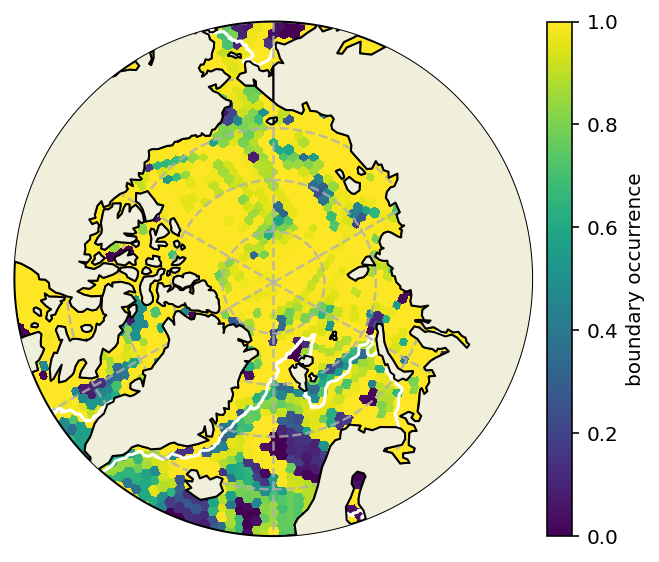

In [35]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_boundary_201803_subD30[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = 'viridis', vmin=0, vmax=1,
                                            size = (5,5),
#                                             export = f"{comName}.png",
                                            cbar=True,
                                            polar = True,
                                            units = "boundary occurrence"
                                            )
ax.contour(ice_ds_201803.longitude, ice_ds_201803.latitude[1680:], ice_ds_201803.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/average_boundary_ensemble_masked_network_Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24_Cico6_subD30_mt2.png", dpi=300, bbox_inches='tight')

# September 2018

In [36]:
ice_ds_201809 = xr.open_dataset(meanDir + "mercatorglorys12v1_gl12_mean_201809.nc")

## 90 days

In [37]:
with open(comdir + f"ensemble_masked_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico6_mt2/ensembleResults_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico6_mt2.pickle", 'rb') as pickFile:
    results = pickle.load(pickFile) 
        
codelengths_201809 = results['codelengths']
globalMixing_201809 = results['globalMixing']
globalCoherence_201809 = results['globalCoherence']
avg_mixing_201809 = results['avg_mixing']
avg_coherence_201809 = results['avg_coherence']
avg_boundary_201809 = results['avg_boundary']

In [38]:
qualityparametersDF_201809 = pd.DataFrame({"Codelength" : codelengths_201809,
                                    "Global Mixing" : globalMixing_201809,
                                    "Global Coherence" : globalCoherence_201809}, 
                                )

In [39]:
qualityparametersDF_201809.corr()

,Codelength,Global Mixing,Global Coherence
Codelength,1.000000,-0.242383,0.012697
Global Mixing,-0.242383,1.000000,-0.648155
Global Coherence,0.012697,-0.648155,1.000000


In [44]:
qualityparametersDF_201809.corr(method=lambda x, y: pearsonr(x, y)[1])

,Codelength,Global Mixing,Global Coherence
Codelength,1.000000,1.511115e-02,9.002199e-01
Global Mixing,0.015111,1.000000e+00,3.103465e-13
Global Coherence,0.900220,3.103465e-13,1.000000e+00


In [45]:
qualityparametersDF_201809.mean()

Codelength          6.217599
Global Mixing       0.416197
Global Coherence    0.799088
dtype: float64

In [46]:
qualityparametersDF_201809.var()

Codelength          0.000075
Global Mixing       0.000007
Global Coherence    0.000028
dtype: float64

In [47]:
qualityparametersDF_201809.std()

Codelength          0.008645
Global Mixing       0.002638
Global Coherence    0.005306
dtype: float64

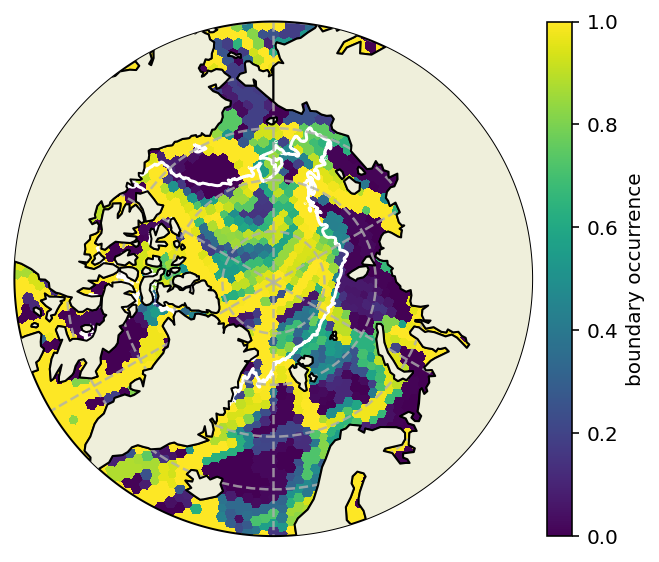

In [48]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             results['avg_boundary'][myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = 'viridis', vmin=0, vmax=1,
                                            size = (5,5),
#                                             export = f"{comName}.png",
                                            cbar=True,
                                            polar = True,
                                            units = "boundary occurrence"
                                            )
ax.contour(ice_ds_201809.longitude, ice_ds_201809.latitude[1680:], ice_ds_201809.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/average_boundary_ensemble_masked_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico6_mt2.png", dpi=300, bbox_inches='tight')

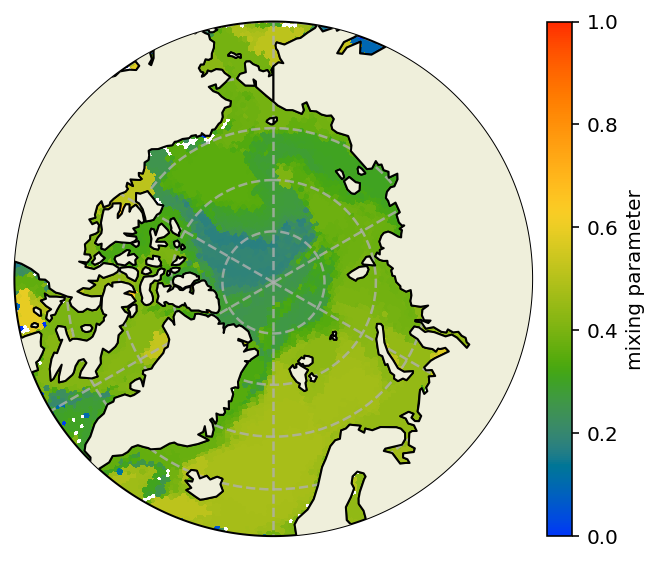

In [53]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_mixing_201809[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
                                             export = f"average_mixing_201809.png",
                                             cbar=True,
                                             polar = True,
                                             units = "mixing parameter"
                                            )

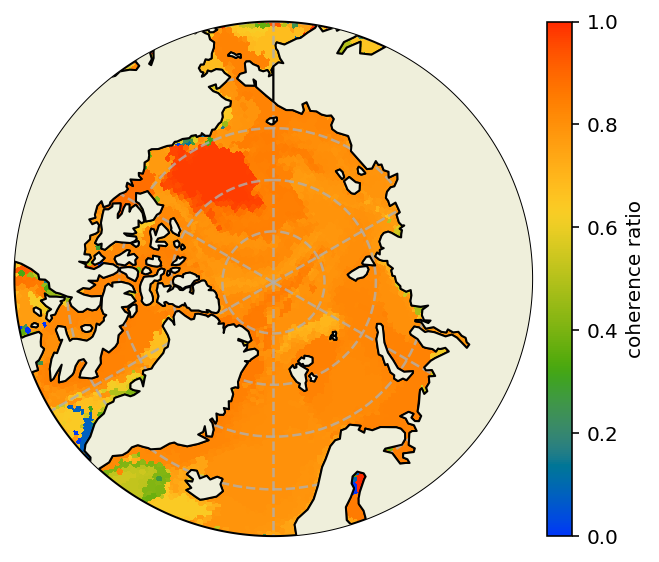

In [54]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_coherence_201809[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = cc.cm.rainbow, vmin=0, vmax=1,
                                             size = (5,5),
                                             export = f"average_coherence_201809.png",
                                             cbar=True,
                                             polar = True,
                                             units = "coherence ratio"
                                            )

# 30 Days

In [50]:
with open(comdir + f"ensemble_masked_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico6_subD30_mt2/ensembleResults_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico6_subD30_mt2.pickle", 'rb') as pickFile:
    results = pickle.load(pickFile) 
        
codelengths_201809_subD30 = results['codelengths']
globalMixing_201809_subD30 = results['globalMixing']
globalCoherence_201809_subD30 = results['globalCoherence']
avg_mixing_201809_subD30 = results['avg_mixing']
avg_coherence_201809_subD30 = results['avg_coherence']
avg_boundary_201809_subD30 = results['avg_boundary']

In [51]:
qualityparametersDF_201809_subD30 = pd.DataFrame({"Codelength" : codelengths_201809_subD30,
                                    "Global Mixing" : globalMixing_201809_subD30,
                                    "Global Coherence" : globalCoherence_201809_subD30}, 
                                )

In [52]:
qualityparametersDF_201809_subD30.corr()

,Codelength,Global Mixing,Global Coherence
Codelength,1.000000,-0.207451,0.162913
Global Mixing,-0.207451,1.000000,-0.792095
Global Coherence,0.162913,-0.792095,1.000000


In [53]:
qualityparametersDF_201809_subD30.corr(method=lambda x, y: pearsonr(x, y)[1])

,Codelength,Global Mixing,Global Coherence
Codelength,1.000000,3.835755e-02,1.053419e-01
Global Mixing,0.038358,1.000000e+00,9.862621e-23
Global Coherence,0.105342,9.862621e-23,1.000000e+00


In [54]:
qualityparametersDF_201809_subD30.mean()

Codelength          6.081921
Global Mixing       0.386031
Global Coherence    0.821872
dtype: float64

In [55]:
qualityparametersDF_201809_subD30.var()

Codelength          0.000040
Global Mixing       0.000006
Global Coherence    0.000019
dtype: float64

In [56]:
qualityparametersDF_201809_subD30.std()

Codelength          0.006300
Global Mixing       0.002369
Global Coherence    0.004343
dtype: float64

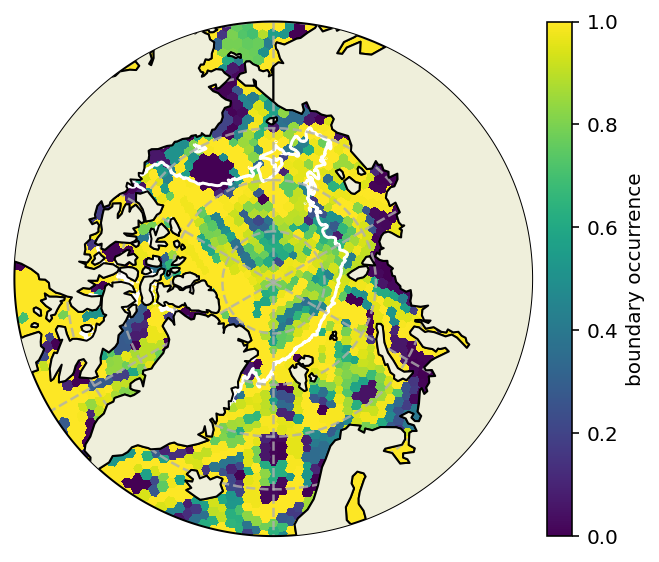

In [57]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_boundary_201809_subD30[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = 'viridis', vmin=0, vmax=1,
                                            size = (5,5),
#                                             export = f"{comName}.png",
                                            cbar=True,
                                            polar = True,
                                            units = "boundary occurrence"
                                            )
ax.contour(ice_ds_201809.longitude, ice_ds_201809.latitude[1680:], ice_ds_201809.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())
plt.savefig(f"figures/average_boundary_ensemble_masked_network_Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24_Cico6_subD30_mt2.png", dpi=300, bbox_inches='tight')